# Notebook to correlate vis 0.6 spectra of satellite images and measured sun intensity from weather stations

In [1]:
#### Functions to load data

from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
import rasterio
from datetime import datetime
from tensorflow import keras
from PIL import Image
from matplotlib.patches import Circle
from datetime import date

## Locations of weather stations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [2]:
weather_station_coordinates = dict()
weather_station_coordinates["Tallinn-Harku"] = [59.398055, 24.602778]
weather_station_coordinates["Narva"] = [59.389444, 28.109167]
weather_station_coordinates["Pärnu"] = [58.384556, 24.485197]
weather_station_coordinates["Roomassaare"] = [58.218056, 22.506389]
weather_station_coordinates["Tartu-Tõravere"] = [58.264167, 26.461389]
weather_station_coordinates["Tiirikoja"] = [58.865278, 26.952222]
weather_station_coordinates["Vilsandi"] = [58.382778, 21.814167]

## Load satellite images

In [3]:


"""
Function for loading the satellite images
Arguments:
 selectedDataset - can be "2019-07" - e.g. specific month
                          "" - all months
 pictureTypes - list defining what sort of constellations are loaded
                "dnc" - 
                "dnm" - 24-hour Microphysics RGB

 pictureSize - Size to resize images to after they are read from disk. Defaults to (256, 256).
Returns:
  2 dictionaries
  dates - dates corresponding to pictures
  pictures - satellite pictures
"""


def loadSatelliteImages(selectedDatasets=["2019-07"], pictureTypes=["dnc", "dnm"], pictureSize=(256, 256)):
    pictures = defaultdict(lambda: defaultdict(list))
    dates = defaultdict(lambda: defaultdict(list))

    for selectedDataset in selectedDatasets:
        for pictureType in pictureTypes:
            satellitePictureNames = os.listdir(os.path.join(".", "data", selectedDataset, pictureType))

            for satellitePictureName in satellitePictureNames:
                # Load image
                imageDateStr = satellitePictureName.replace("dnc-", "").replace("dnm-", "").replace(".png", "")
                #Parse date to datetime 2019-07-01-05-45
                imageDate = datetime.strptime(imageDateStr, "%Y-%m-%d-%H-%M")
                img = image.load_img(os.path.join(".", "data", selectedDataset,
                                                  pictureType, satellitePictureName),
                                     target_size=pictureSize)
                # Convert to np array and add to list
                pictures[selectedDataset][pictureType].append(np.array(img))
                dates[selectedDataset][pictureType].append(imageDate)
            dates[selectedDataset][pictureType] = np.array(dates[selectedDataset][pictureType])
            pictures[selectedDataset][pictureType] = np.array(pictures[selectedDataset][pictureType])
            #Argsort
            sortedDates = np.argsort(dates[selectedDataset][pictureType])
            dates[selectedDataset][pictureType] = dates[selectedDataset][pictureType][sortedDates]
            pictures[selectedDataset][pictureType] = pictures[selectedDataset][pictureType][sortedDates]

    return pictures, dates


In [57]:
###### Some important variables
 
npixel = 128 # Define the pixel size of images
pictureType = ["dnc"]#, "dnm"]
dataSets = ["2019-07","2019-08","2019-09","2019-10"]

In [5]:
sat, labels = loadSatelliteImages(selectedDatasets=dataSets, pictureTypes=pictureType, pictureSize=(npixel, npixel))

## Relate points in satellite image to weather station coordinates

In [6]:
def findPixel(latsMatrix, lonsMatrix, coordLat, coordLon):
    #Iterate over lattitude and longitude matrix to find coord
    accuracyDif = 0.07
    for i in range(len(latsMatrix)):
        for j in range(len(lonsMatrix[i])):
            currentLat = latsMatrix[i][j]
            currentLon = lonsMatrix[i][j]
            if(np.abs(currentLat-coordLat)<accuracyDif):
                if(np.abs(currentLon-coordLon)<accuracyDif):
                    return (j, i)
    #Nothing was found return
    return (None, None)

In [7]:
def resizeLatsLonsMatrix(latsMatrix, lonsMatrix, targetSize):
    result = [latsMatrix, lonsMatrix]
    for i in range(len(result)):
        pil = Image.fromarray(result[i])
        resized = pil.resize((targetSize,targetSize))
        resizedArray = np.array(resized)
        result[i] = resizedArray
    return result

In [8]:
#The initial coordinate matrix is for images 650x650
lats650 = np.load("./OstlandA/OstlandA-lats.npy")
lons650 = np.load("./OstlandA/OstlandA-lons.npy")
#Convert them to size (npixel x npixel)
lats_npixel, lons_npixel = resizeLatsLonsMatrix(lats650, lons650, npixel)

In [9]:
#Find the pixels where the weather stations are located
weather_station_loc_pixels = dict()
for station in weather_station_coordinates.keys():
    weather_station_loc_pixels[station]=findPixel(lats_npixel, lons_npixel, 
                          weather_station_coordinates[station][0], 
                          weather_station_coordinates[station][1])


In [10]:
weather_station_loc_pixels

{'Tallinn-Harku': (65, 51),
 'Narva': (92, 42),
 'Pärnu': (68, 71),
 'Roomassaare': (53, 79),
 'Tartu-Tõravere': (85, 68),
 'Tiirikoja': (86, 55),
 'Vilsandi': (47, 77)}

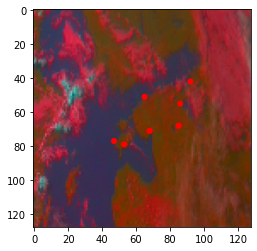

In [12]:
#Check that the locations are correct on one random image
fig, ax = plt.subplots(1)
ax.imshow(sat["2019-08"][pictureType[0]][450])
for station in weather_station_loc_pixels.keys():
    ax.add_patch(Circle((weather_station_loc_pixels[station][0],weather_station_loc_pixels[station][1]), radius=1.5, color="red"))

In [132]:
# Normalize the of satellite images to the 0-1 range.
for dataSet in sat.keys():
    for pictureType in sat[dataSet].keys():
        sat[dataSet][pictureType] = sat[dataSet][pictureType] / 255

## Load solar intensity data from weather stations

In [13]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [14]:
#Create datetime object from year, month and day
def createDateTimeColumn(df):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)]
    df["dateTime"] = dateTimes

In [15]:
#Load initial data
hourly_sun_intensity = pd.read_excel('./data/2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [16]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"

for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)


In [17]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [18]:
#hourly_sun_intensity

In [19]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

#Drop rows where sun is not shined for an hour
#for columnName in hourly_sun_intensity.columns:
#    print(columnName)
#    if "solar" in columnName:
#        hourly_sun_intensity = hourly_sun_intensity[hourly_sun_intensity[columnName]!=0]

In [21]:
#Create datetime object column for finding matching satellite images and rows of weather station data
createDateTimeColumn(hourly_sun_intensity)

## Load weather data from weather stations

In [61]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", "Õhutemperatuur °C","Suhteline õhuniiskus %"]

In [62]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [63]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [65]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, 'Tallinn-Harku')
#Get Roomassaare
data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, 'Roomassaare')
#Merge tables
data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

In [66]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "Vilsandi")
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [67]:
##Get Parnu
data_parnu1 = getFromXlsx("./data/Parnu-Sauga_01.12.2004-31.03.2019.xlsx", selectedColumns, 'Pärnu')
data_parnu2 = getFromXlsx("./data/Parnu_01.04.2019-2020.xlsx", selectedColumns, 'Pärnu')
data_parnu = data_parnu1.append(data_parnu2)
##Merge tables
data_weather = data_weather.merge(data_parnu, how='left', on=["y", "m", "d", "time"])

In [68]:
#Get Tartu
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, 'Tartu-Tõravere')
#Merge tables
data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])


In [69]:
#Get Narva
data_Narva = getFromXlsx("./data/Narva_19.12.2013-2020.xlsx", selectedColumns, "Narva")
data_weather = data_weather.merge(data_Narva, how='left', on=["y", "m", "d", "time"])

In [70]:
#Get Tiirikoja
data_Tiirikoja = getFromXlsx("./data/Tiirikoja_2004-2020.xlsx", selectedColumns, "Tiirikoja")
data_weather = data_weather.merge(data_Tiirikoja, how='left', on=["y", "m", "d", "time"])

In [71]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

In [72]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
from datetime import timedelta
import copy
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)+timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [73]:
#When predicting we use the weather data of previous hour and predicted future satellite image 
#to predict future solar intensity of next hour

data_weather_shifted = shiftDateTime(data_weather, 1)

In [74]:
#Create datetime object column for finding matching satellite images and rows of weather station data
createDateTimeColumn(data_weather_shifted)

## Final step: Join intensity and shifted weather station data

In [75]:
data_solar_weather = hourly_sun_intensity.merge(data_weather_shifted, how='left', on=["dateTime"])

In [76]:
data_solar_weather

y_x  m_x  d_x    time_x  solar_Narva  solar_Pärnu  solar_Haapsalu  \
0      2010    4   14  12:00:00        634.0        384.0           652.0   
1      2010    4   14  13:00:00        552.0        297.0           577.0   
2      2010    4   14  14:00:00        450.0        381.0           484.0   
3      2010    4   14  15:00:00        326.0        375.0           384.0   
4      2010    4   14  16:00:00        117.0        239.0           250.0   
...     ...  ...  ...       ...          ...          ...             ...   
88783  2020   12   31  19:00:00          0.0          0.0             0.0   
88784  2020   12   31  20:00:00          0.0          0.0             0.0   
88785  2020   12   31  21:00:00          0.0          0.0             0.0   
88786  2020   12   31  22:00:00          0.0          0.0             0.0   
88787  2020   12   31  23:00:00          0.0          0.0             0.0   

       solar_Tallinn-Harku  solar_Roomassaare  solar_Tartu-Tõravere  ...  \
0                      603              673.0                   371  ...   
1                      540              611.0                   328  ...   
2                      441              511.0                   317  ...   
3                      319              380.0                   265  ...   
4                      189              237.0                   101  ...   
...                    ...                ...                   ...  ...   
88783                    0                0.0                     0  ...   
88784                    0                0.0                     0  ...   
88785                    0                0.0                     0  ...   
88786                    0                0.0                     0  ...   
88787                    0                0.0                     0  ...   

       temp_Vilsandi  rel_humidity_Vilsandi temp_Pärnu  rel_humidity_Pärnu  \
0                NaN                    NaN        NaN                 NaN   
1                NaN                    NaN        NaN                 NaN   
2                NaN                    NaN        NaN                 NaN   
3                NaN                    NaN        NaN                 NaN   
4                NaN                    NaN        NaN                 NaN   
...              ...                    ...        ...                 ...   
88783            3.5                   96.0        1.5                98.0   
88784            3.7                   95.0        1.8                95.0   
88785            3.4                   96.0        1.9                96.0   
88786            3.4                   94.0        1.8                96.0   
88787            2.9                   96.0        1.7                97.0   

       temp_Tartu-Tõravere  rel_humidity_Tartu-Tõravere temp_Narva  \
0                      NaN                          NaN        NaN   
1                      NaN                          NaN        NaN   
2                      NaN                          NaN        NaN   
3                      NaN                          NaN        NaN   
4                      NaN                          NaN        NaN   
...                    ...                          ...        ...   
88783                  1.1                         97.0        0.8   
88784                  1.1                         93.0        0.7   
88785                  1.0                         96.0        0.8   
88786                  0.8                         95.0        0.8   
88787                  0.5                         96.0        0.9   

       rel_humidity_Narva  temp_Tiirikoja  rel_humidity_Tiirikoja  
0                     NaN             NaN                     NaN  
1                     NaN             NaN                     NaN  
2                     NaN             NaN                     NaN  
3                     NaN             NaN                     NaN  
4                     NaN             NaN           

### As satelite images are from 2019, we can drop other years

In [77]:
data_solar_weather = data_solar_weather[data_solar_weather.y_x == 2019]

### Filter the data for matching

In [128]:
#Mask for selecting right rows of weather data and drop others

mask = np.asarray([data_solar_weather["dateTime"].iloc[i] in labels[dataSets[0]][pictureType[0]] for i in range(len(data_solar_weather["dateTime"]))])

for j in range(1,len(dataSets)):
    mask_aux = np.asarray([data_solar_weather["dateTime"].iloc[i] in labels[dataSets[j]][pictureType[0]] for i in range(len(data_solar_weather["dateTime"]))])
    mask = mask + mask_aux
data_solar_weather_filtered = data_solar_weather[mask]

In [129]:
#Remove also first row as we do not have these images
data_solar_weather_filtered = data_solar_weather_filtered.iloc[1:] 

# Start predicting

## 1) Predict the satellite image of the given time by using previous images and trained RNN model

In [133]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imageLabels - timestamps of images
weatherDataLabels - timestamps of weather data
imagesInSample - number of images in data row
"""
def createDataSetFromImages(dataDict, X_imagetype, Y_imagetype, imageLabels, weatherDataLabels, selectChannelX=None, selectChannelY=None, imagesInSample=6):
    X = []
    y = []
    y_times = []
    for month in dataDict.keys():
        if selectChannelX is None:
            X_subset = dataDict[month][X_imagetype]
        else:
            X_subset = dataDict[month][X_imagetype][:,:,:,selectChannelX]
            # Add a channel dimension if using only one channel
            X_subset = np.expand_dims(X_subset, axis=-1)

        if selectChannelY is None:
            y_subset = dataDict[month][Y_imagetype]
            y_times_subset = imageLabels[month][Y_imagetype]
        else:
            y_subset = dataDict[month][Y_imagetype][:,:,:,selectChannelY]
            y_subset = np.expand_dims(y_subset, axis=-1)
        y_times_subset = imageLabels[month][Y_imagetype]
        assert len(X_subset)==len(y_subset) # Lengths must match
        for i in range(0, len(X_subset)-imagesInSample-1):
            #Select only images, which last frame corresponds to time for which we
            #have solar intensity
            selected_y_last_frame_time = y_times_subset[i+1+imagesInSample]
            if(selected_y_last_frame_time in weatherDataLabels):
                #Select images so that y is shifted by one frame
                selected_X = X_subset[i:i+imagesInSample]
                selected_y = y_subset[i+1:i+1+imagesInSample]
            
                #print(np.sum(selected_X[1]-selected_y[0]))
                X.append(selected_X)
                y.append(selected_y)
                y_times.append(selected_y_last_frame_time)
    return np.array(X), np.array(y), y_times

In [134]:
#Select only satellite images as prediction targets, where the last frame of RNN is in Weather data table
labelsAsTImestamps = [pd.Timestamp(value) for value in data_solar_weather_filtered.dateTime.values]
X, y, y_times = createDataSetFromImages(sat, "dnc", "dnc", labels, labelsAsTImestamps, 1, 1)

In [135]:
#Load trained RNN model
from tensorflow import keras
model = keras.models.load_model('savedModel_2a')

2021-12-08 19:18:22.256204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 19:18:22.257233: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [136]:
#Precict future sat image for chosen times
# Takes time
y_predicted = []
for i in range(len(X)):
    prediction = model.predict(np.expand_dims(X[i], axis=0))
    # In reality we are interested in the last predicted frame
    y_predicted+=[prediction[0][-1]]

2021-12-08 19:21:36.004358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Link together points on satellite images and weather data

In [149]:
mask = [(y_time in labelsAsTImestamps) for y_time in y_times]
mask2 = [timeStamp in y_times for timeStamp in labelsAsTImestamps]
y_times_predicted = np.array(y_times)[mask]
y_predicted = np.array(y_predicted)[mask]
data_solar_weather_predicted = data_solar_weather_filtered[mask2]

In [150]:
#Safety check for perfect match
for j in range(len(y_times_predicted)):
    if(np.datetime64(y_times_predicted[j])!=np.datetime64(data_solar_weather_predicted["dateTime"].iloc[j])):
        print("Date mismatch")

In [158]:
y_predicted_trimmed = y_predicted[:,-1]#Later delete
y_predicted_trimmed.shape

(2944, 128, 128, 1)

### Transforming points on images and sunlight data to dataset

In [161]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imagesInSample - number of images in data row
"""
def createDataSetFromImagesAndStations(satelliteData, satellite_labels, intensityData, 
                                       weatherStationPixels):
    X = []
    y = []
    
    #For each image
    for i in range(len(satelliteData)):
        selectedImageHour = satellite_labels[i].hour
        selectedImage = satelliteData[i]
        #For each weather station
        for weatherStation in weatherStationPixels.keys():
            selectedStation = weatherStationPixels[weatherStation]
            X+=[[selectedImageHour] +[intensityData.iloc[i][("rel_humidity_"+weatherStation)]] + [intensityData.iloc[i][("temp_"+weatherStation)]] + list(selectedImage[selectedStation[0], selectedStation[1]])]
            #X+=[[selectedImage[selectedStation[0], selectedStation[1]]]]
            y+=[intensityData.iloc[i][("solar_"+weatherStation)]]


            
    return np.array(X), np.array(y)

In [163]:
X_images_weather, y_intensity = createDataSetFromImagesAndStations(y_predicted_trimmed, #Fix later by removing trimmed
                                          y_times_predicted,
                                   data_solar_weather_filtered, weather_station_loc_pixels)

## Train and predict solar intensity using feature from satellite image and weather data

In [165]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_images_weather, y_intensity, test_size=0.2, random_state=111)

In [179]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [181]:
results_df = pd.DataFrame()

In [186]:
rf= RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
mean_squared_error(y_test, rf.predict(X_test_scaled), squared = False)

99.83333866123292

In [187]:
############### Random Forest ##############################

n_estimatorss = [10, 20,30]
max_depths=[5, 10,20, 30]
min_samples_splits=[4,6,8,16]
seeds = [1]
results_df = pd.DataFrame(columns=['model',"seed","n_estimators","max_depth","min_samples_split",'TrainError', 'ValError', 'deltaErrors'])
for seed in seeds:
    for n_estimator in n_estimatorss:
        for max_d in max_depths:
            for min_ss in min_samples_splits:
                rf = RandomForestRegressor(criterion="squared_error", n_estimators=n_estimator, max_depth=max_d, min_samples_split=min_ss, random_state=seed).fit(X_train_scaled, y_train)
                trainError = mean_squared_error(y_train, rf.predict(X_train_scaled), squared = False)
                valError = mean_squared_error(y_test, rf.predict(X_test_scaled), squared = False)
                results_df = results_df.append({'model': 'RF',"seed":seed,"n_estimators":n_estimator,"max_depth":max_d,"min_samples_split":min_ss,"TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

In [188]:
results_df.sort_values("ValError")

model seed n_estimators max_depth min_samples_split  TrainError  \
7     RF    1           10        10                16   87.758899   
39    RF    1           30        10                16   86.591765   
23    RF    1           20        10                16   87.058162   
38    RF    1           30        10                 8   85.290534   
5     RF    1           10        10                 6   86.288788   
37    RF    1           30        10                 6   84.908565   
6     RF    1           10        10                 8   86.608928   
4     RF    1           10        10                 4   85.992957   
36    RF    1           30        10                 4   84.579391   
21    RF    1           20        10                 6   85.496000   
22    RF    1           20        10                 8   85.854243   
43    RF    1           30        20                16   70.795882   
20    RF    1           20        10                 4   85.151736   
47    RF    1           30        30                16   70.584664   
27    RF    1           20        20                16   71.331479   
31    RF    1           20        30                16   71.096425   
11    RF    1           10        20                16   72.635816   
15    RF    1           10        30                16   72.438756   
42    RF    1           30        20                 8   58.312279   
46    RF    1           30        30                 8   57.643144   
45    RF    1           30        30                 6   52.023663   
26    RF    1           20        20                 8   58.911142   
41    RF    1           30        20                 6   52.984549   
30    RF    1           20        30                 8   58.183108   
40    RF    1           30        20                 4   46.535439   
29    RF    1           20        30                 6   52.654267   
44    RF    1           30        30                 4   45.092362   
25    RF    1           20        20                 6   53.688897   
10    RF    1           10        20                 8   60.764214   
14    RF    1           10        30                 8   60.107329   
24    RF    1           20        20                 4   47.475287   
28    RF    1           20        30                 4   45.945491   
9     RF    1           10        20                 6   55.758733   
13    RF    1           10        30                 6   54.857696   
8     RF    1           10        20                 4   49.936620   
12    RF    1           10        30                 4   48.651838   
32    RF    1           30         5                 4  107.276054   
33    RF    1           30         5                 6  107.276054   
34    RF    1           30         5                 8  107.276054   
35    RF    1           30         5                16  107.276054   
16    RF    1           20         5                 4  107.846186   
19    RF    1           20         5                16  107.846186   
18    RF    1           20         5                 8  107.846186   
17    RF    1           20         5                 6  107.846186   
3     RF    1           10         5                16  108.430721   
2     RF    1           10         5                 8  108.430721   
1     RF    1           10         5                 6  108.430721   
0     RF    1           10         5                 4  108.430721   

      ValError  deltaErrors  
7    97.735362     9.976463  
39   97.740362    11.148598  
23   97.768097    10.709936  
38   97.884102    12.593569  
5    97.884264    11.595476  
37   97.900497    12.991932  
6    97.902112    11.293184  
4    97.910011    11.917054  
36   97.925252    13.345862  
21   97.971616    12.475616  
22   97.973911    12.119668  
43   98.035758    27.239876  
20   98.040841    12.889105  
47   98.095674    27.511010  
27   98.373707    27.042228  
31   98.413368    27.316943  
11   98.617759    25.981943  
15   98.666699    26.227943  
42

### Gradient Boosting

In [189]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


############### HistGradientBoostingRegressor ##############################

learning_rates = [0.3, 0.2, 0.1, 0.05, 0.01]
l2_regularizations=[0, 0.1, 0.2]
results_gb_df = pd.DataFrame(columns=['model',"lr","l2",'TrainError', 'ValError', 'deltaErrors'])
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        gb = HistGradientBoostingRegressor(l2_regularization=l2_regularization, learning_rate=learning_rate).fit(X_train_scaled, y_train)
        trainError = mean_squared_error(y_train, gb.predict(X_train_scaled), squared = False)
        valError = mean_squared_error(y_test, gb.predict(X_test_scaled), squared = False)
        results_gb_df = results_gb_df.append({'model': 'GB', "lr":learning_rate , "l2":l2_regularization, "TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

/home/main/anaconda3/envs/metsat/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [190]:
results_gb_df.sort_values("ValError")

model    lr   l2  TrainError    ValError  deltaErrors
10    GB  0.05  0.1   91.012953   97.145827     6.132875
6     GB  0.10    0   89.077361   97.332581     8.255220
7     GB  0.10  0.1   87.368979   97.344445     9.975465
8     GB  0.10  0.2   87.552009   97.471908     9.919899
1     GB  0.30  0.1   88.408171   97.474616     9.066446
9     GB  0.05    0   91.140789   97.609063     6.468274
11    GB  0.05  0.2   91.195034   97.624035     6.429001
2     GB  0.30  0.2   88.645891   97.690384     9.044493
4     GB  0.20  0.1   87.224864   97.952588    10.727724
3     GB  0.20    0   87.797257   98.053470    10.256213
5     GB  0.20  0.2   90.537488   98.640877     8.103390
0     GB  0.30    0   85.468154   98.987304    13.519150
13    GB  0.01  0.1  121.018696  122.264856     1.246160
12    GB  0.01    0  120.825758  122.268008     1.442251
14    GB  0.01  0.2  121.190400  122.319287     1.128887

### KNN

In [191]:
from sklearn.neighbors import KNeighborsRegressor

############### KNNRegressor ##############################

neighbors = [5,7,9,11,13,17,21]

results_knn_df = pd.DataFrame(columns=['model',"neighbors",'TrainError', 'ValError', 'deltaErrors'])

for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train_scaled, y_train)
    trainError = mean_squared_error(y_train, knn.predict(X_train_scaled), squared = False)
    valError = mean_squared_error(y_test, knn.predict(X_test_scaled), squared = False)
    results_knn_df = results_knn_df.append({'model': 'KNN', "neighbors":neighbor, "TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)


In [192]:
results_knn_df.sort_values("ValError")

model neighbors  TrainError    ValError  deltaErrors
5   KNN        17   92.949835   99.225890     6.276055
6   KNN        21   94.126867   99.242046     5.115180
4   KNN        13   91.419648   99.408243     7.988595
3   KNN        11   90.555371  100.139473     9.584102
2   KNN         9   89.541975  100.867134    11.325159
1   KNN         7   87.411306  102.861049    15.449743
0   KNN         5   83.304239  106.198746    22.894507

In [193]:
bestResults = dict()
bestResults["RF"] = results_df.sort_values(by="ValError").iloc[0]
bestResults["GB"] = results_gb_df.sort_values(by="ValError").iloc[0]
bestResults["KNN"] = results_knn_df.sort_values(by="ValError").iloc[0]

RF
97.73536233630496
GB
97.14582738106289
KNN
99.22589014862726


Text(0, 0.5, 'RMSE [W/m$^{2}$]')

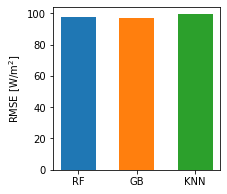

In [194]:
results = [(bestResults[key]["ValError"]) for key in bestResults.keys()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
for i in range(len(bestResults.keys())):
    print(list(bestResults.keys())[i])
    print(results[i])
    ax.bar(list(bestResults.keys())[i] ,results[i], width=0.6)
    #ax.bar(list(bestResults.keys()) ,results, width=0.6)
ax.set_ylabel(r"RMSE [W/m$^{2}$]")